In [1]:
import sys
sys.path.insert(0, '../../../../fastshap_tf/')
from fastshap import ResizeMask

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
import pickle
import numpy as np

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

from datetime import datetime
import os

In [4]:
from tensorflow.keras.layers import (Input, Layer, Dense, Lambda, 
                                     Dropout, Multiply, BatchNormalization, 
                                     Reshape, Concatenate, Conv2D, Permute)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications.resnet50 import ResNet50

In [5]:
import pandas as pd
from functools import reduce

In [6]:
#Select GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [7]:
# IMPORTANT: SET RANDOM SEEDS FOR REPRODUCIBILITY
os.environ['PYTHONHASHSEED'] = str(420)
import random
random.seed(420)
np.random.seed(420)

In [8]:
#################### Load Images + Predictions ####################
images_dir = os.path.join('../', 'images')
images = np.load(os.path.join(images_dir, 'processed_images.npy'), allow_pickle=True)


preds_path = os.path.join(images_dir, 'predictions.npy')
preds = np.load(preds_path, allow_pickle=True)
preds_discrete = np.eye(10)[preds.argmax(1)]

In [9]:
#################### Load Evaluator Model ####################
class Random_Bernoulli_Sampler(Layer):
    '''
    Layer to Sample r
    '''
    def __init__(self, num_features, **kwargs):
        super(Random_Bernoulli_Sampler, self).__init__(**kwargs)
        
        self.num_features = num_features
        
        
    def call(self,  logits):
        batch_size = tf.shape(logits)[0]
        
        u = tf.random.uniform(shape=(batch_size, self.num_features),
                                    minval=np.finfo(
                                        tf.float32.as_numpy_dtype).tiny,
                                    maxval=1.0) 

        r = K.cast(tf.stop_gradient(u > 0.5), tf.float32)
        
        return r

    
INPUT_SHAPE = (224,224,3)
base_model = ResNet50(
    include_top=False, weights='imagenet', 
    input_shape=INPUT_SHAPE, pooling='avg'
)
base_model.trainable = True

model_input = Input(shape=INPUT_SHAPE, dtype='float32', name='input')
R = Random_Bernoulli_Sampler(14*14)(model_input)
R = ResizeMask(in_shape=INPUT_SHAPE, mask_size=14*14)(R)
xr = Multiply()([model_input, R])

net = base_model(xr)
out = Dense(10, activation='softmax')(net)

evaluator_model = Model(model_input, out)

evaluator_weights = 'evaluator/model_weights.h5'
evaluator_model.load_weights(evaluator_weights)
evaluator_model = Sequential(   
            [l for l in evaluator_model.layers[-2:]]
        )
evaluator_model.trainable = False

OPTIMIZER = tf.keras.optimizers.Adam(1e-3)
METRICS = [ 
  tf.keras.metrics.AUC(name='auroc'),
  tf.keras.metrics.AUC(curve='PR', name='auprc'),
  tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='accuracy'),
]

evaluator_model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMIZER,
    metrics=METRICS,
)

# Run Evaluations for Each Method and Masking Percent

In [9]:
def log_odds(p):
    p = np.clip(p, 0.0001, 0.9999)
    return np.log(p/(1-p))

In [11]:
methods = ['fastshap', 'kernelshap', 'kernelshap_plus', 'gradcam', 'integratedgradients', 'smoothgrad', 'deepshap', 'cxplain']
# for method in methods:
for method in methods:
    print(method)
    evaluation_results = {}
    
    #################### Load Masks ####################
    if method in ['gradcam', 'integratedgradients', 'smoothgrad','deepshap']:
        method_dir = os.path.join('../', method)
    else:
        method_dir = os.path.join('../', method, 'results')
    
    with open(os.path.join(method_dir, 'masks.pkl'), 'rb') as f:
        mask_dict = pickle.load(f)
    
    evaluation_results['acc'] = {}
    evaluation_results['auroc'] = {}
    evaluation_results['auprc'] = {}
    evaluation_results['preds'] = {}
    evaluation_results['log_odds'] = {}
    
    for p, masks in mask_dict.items():
        #################### Mask Images ####################
        if len(masks.shape) < 4:
            masks = np.expand_dims(masks, -1)
        masked_images = images * masks

        #################### Evaluate Masked Images ####################
        _, auroc, auprc, acc = evaluator_model.evaluate(x = masked_images, 
                                                        y = preds_discrete)
        masked_preds = evaluator_model.predict(masked_images)
        logodds = np.mean(log_odds(masked_preds[preds_discrete==1]))
        
        evaluation_results['acc'][p] = acc
        evaluation_results['auroc'][p] = auroc
        evaluation_results['auprc'][p] = auprc
        evaluation_results['preds'][p] = masked_preds
        evaluation_results['log_odds'][p] = logodds
    
    #################### Save ####################
    with open(os.path.join(method_dir, 'evaluation_results_out.pkl'), 'wb') as f:
        pickle.dump(evaluation_results, f)

fastshap
32/32 [==============================] - 1s 33ms/step - loss: 3.1793 - auroc: 0.5204 - auprc: 0.1059 - accuracy: 0.1000
kernelshap
32/32 [==============================] - 1s 33ms/step - loss: 3.1542 - auroc: 0.5232 - auprc: 0.1119 - accuracy: 0.1070
kernelshap_plus
32/32 [==============================] - 1s 33ms/step - loss: 3.1733 - auroc: 0.5102 - auprc: 0.1021 - accuracy: 0.1050
gradcam
32/32 [==============================] - 1s 33ms/step - loss: 3.1611 - auroc: 0.5213 - auprc: 0.1074 - accuracy: 0.1040
integratedgradients
32/32 [==============================] - 1s 33ms/step - loss: 3.1455 - auroc: 0.5254 - auprc: 0.1093 - accuracy: 0.1010
smoothgrad
32/32 [==============================] - 1s 33ms/step - loss: 3.1548 - auroc: 0.5267 - auprc: 0.1084 - accuracy: 0.1050
deepshap
32/32 [==============================] - 1s 33ms/step - loss: 3.1020 - auroc: 0.5334 - auprc: 0.1114 - accuracy: 0.1140
cxplain
32/32 [==============================] - 1s 33ms/step - loss: 3.1643

In [11]:
# for method in methods:
for method in ['integratedgradients', 'smoothgrad', 'deepshap', 'cxplain']:
    print(method)
    evaluation_results = {}
    
    #################### Load Masks ####################
    if method in ['gradcam', 'integratedgradients', 'smoothgrad','deepshap']:
        method_dir = os.path.join('../', method) 
    else:
        method_dir = os.path.join('../', method, 'results')
    
    with open(os.path.join(method_dir, 'masks_in.pkl'), 'rb') as f:
        mask_dict = pickle.load(f)
    
    evaluation_results['acc'] = {}
    evaluation_results['auroc'] = {}
    evaluation_results['auprc'] = {}
    evaluation_results['preds'] = {}   
    evaluation_results['log_odds'] = {}
    
    for p, masks in mask_dict.items():
        #################### Mask Images ####################
        if len(masks.shape) < 4:
            masks = np.expand_dims(masks, -1)
        masked_images = images * masks

        #################### Evaluate Masked Images ####################
        _, auroc, auprc, acc = evaluator_model.evaluate(x = masked_images, 
                                                        y = preds_discrete)
        masked_preds = evaluator_model.predict(masked_images)
        logodds = np.mean(log_odds(masked_preds[preds_discrete==1]))
        
        evaluation_results['acc'][p] = acc
        evaluation_results['auroc'][p] = auroc
        evaluation_results['auprc'][p] = auprc
        evaluation_results['preds'][p] = masked_preds
        evaluation_results['log_odds'][p] = logodds
    
    #################### Save ####################
    with open(os.path.join(method_dir, 'evaluation_results_in.pkl'), 'wb') as f:
        pickle.dump(evaluation_results, f)

integratedgradients
32/32 [==============================] - 1s 33ms/step - loss: 0.5534 - auroc: 0.9790 - auprc: 0.9145 - accuracy: 0.8360
smoothgrad
32/32 [==============================] - 1s 33ms/step - loss: 0.5558 - auroc: 0.9789 - auprc: 0.9130 - accuracy: 0.8370
deepshap
32/32 [==============================] - 1s 33ms/step - loss: 0.5505 - auroc: 0.9781 - auprc: 0.9122 - accuracy: 0.8390
cxplain
32/32 [==============================] - 1s 33ms/step - loss: 0.5545 - auroc: 0.9785 - auprc: 0.9120 - accuracy: 0.8380


# Graph Degradation

In [10]:
results_dir = 'results'
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

### Load Results

In [11]:
methods = ['fastshap', 'kernelshap', 'kernelshap_plus', 'gradcam', 'integratedgradients', 'smoothgrad', 'deepshap', 'cxplain']
all_results_out = {}
for method in methods:

    if method in ['gradcam', 'integratedgradients', 'smoothgrad','deepshap']:
        method_dir = os.path.join('../', method) 
    else:
        method_dir = os.path.join('../', method, 'results')
    
    with open(os.path.join(method_dir, 'evaluation_results_out.pkl'), 'rb') as f:
        evaluation_results = pickle.load(f)
    
    all_results_out[method] = evaluation_results

In [12]:
all_results_in = {}
for method in methods:

    if method in ['gradcam', 'integratedgradients', 'smoothgrad','deepshap']:
        method_dir = os.path.join('../', method) 
    else:
        method_dir = os.path.join('../', method, 'results')
    
    with open(os.path.join(method_dir, 'evaluation_results_in.pkl'), 'rb') as f:
        evaluation_results = pickle.load(f)
    
    all_results_in[method] = evaluation_results

### Get Bootstrap Results

In [13]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm 

#Initialize Dictionary
for method in methods:
    all_results_out[method]['bootstrap_acc'] = {}
    all_results_out[method]['bootstrap_log_odds'] = {}
    for p in all_results_out[method]['preds'].keys():
        all_results_out[method]['bootstrap_acc'][p] = []
        all_results_out[method]['bootstrap_log_odds'][p] = []

for i in tqdm(range(100)):
    # Get Bootstrap Indices
    inds = np.random.choice(np.arange(1000), 666, replace=False)
    
    for method in methods:
        for p in all_results_out[method]['preds'].keys():
            # Prediction
            y_m = all_results_out[method]['preds'][p][inds]
            y_m = np.eye(10)[y_m.argmax(1)]
            #Label
            y = preds_discrete[inds]
            #Acc
            acc = accuracy_score(y, y_m)
            #Log Odds
            logodds = np.mean(log_odds(y_m[y==1]))
            #Add to Dict
            all_results_out[method]['bootstrap_acc'][p].append(acc)   
            all_results_out[method]['bootstrap_log_odds'][p].append(logodds)   

  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
#Initialize Dictionary
for method in methods:
    all_results_in[method]['bootstrap_acc'] = {}
    all_results_in[method]['bootstrap_log_odds'] = {}
    for p in all_results_in[method]['preds'].keys():
        all_results_in[method]['bootstrap_acc'][p] = []
        all_results_in[method]['bootstrap_log_odds'][p] = []

for i in tqdm(range(100)):
    # Get Bootstrap Indices
    inds = np.random.choice(np.arange(1000), 666, replace=False)
    
    for method in methods:
        for p in all_results_in[method]['preds'].keys():
            # Prediction
            y_m = all_results_in[method]['preds'][p][inds]
            y_m = np.eye(10)[y_m.argmax(1)]
            #Label
            y = preds_discrete[inds]
            #Acc
            acc = accuracy_score(y, y_m)
            #Log Odds
            logodds = np.mean(log_odds(y_m[y==1]))
            #Add to Dict
            all_results_in[method]['bootstrap_acc'][p].append(acc)   
            all_results_in[method]['bootstrap_log_odds'][p].append(logodds)   

  0%|          | 0/100 [00:00<?, ?it/s]

## Graph

In [15]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('/gpfs/data/paulab/nj594/plot/clean.mplstyle')

In [16]:
def acc_error(x):
    return (x*(1-x)/len(images))**.5

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


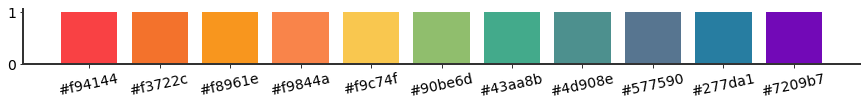

In [17]:
colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1", '7209b7']
colors = ['#'+c for c in colors]
#['#ffca3a', '#ff595e', '#6a4c93', '#1982c4', '#8ac926']
plt.figure(figsize=(15, 1))
plt.bar(np.arange(len(colors)), np.ones(len(colors)), color=colors)
plt.xticks(range(len(colors)), colors, rotation=12)
plt.show()

### Accuracy

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


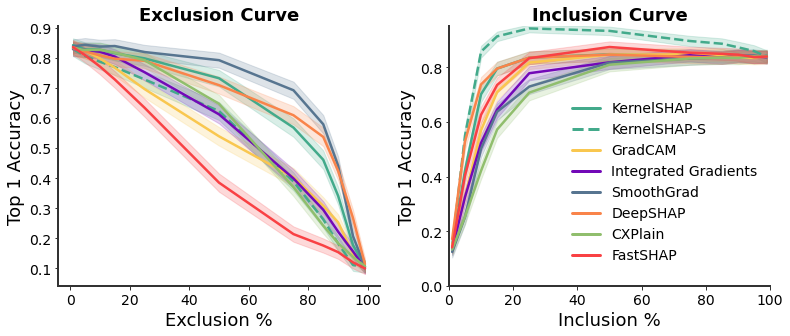

In [18]:
method_names = ['FastSHAP', 'KernelSHAP', 'KernelSHAP-S', 'GradCAM', 
                'Integrated Gradients', 'SmoothGrad', 'DeepSHAP','CXPlain']
accuracy_out = []
for method in methods:
    df =  pd.DataFrame([(int(k), v) for k, v in all_results_out[method]['acc'].items()])
    df.columns = ['Exclusion %', method]
    accuracy_out.append(df)

accuracy_out = reduce(lambda x, y: pd.merge(x, y, on = 'Exclusion %'), accuracy_out)
accuracy_out.columns = ['Exclusion %'] + method_names

#### FIGURE #####
colors = {'FastSHAP':'#f94144', 'KernelSHAP':'#43aa8b', 'KernelSHAP-S':'#43aa8b', 
          'GradCAM':'#f9c74f', 'Integrated Gradients':'#7209b7', 
          'SmoothGrad':'#577590', 'DeepSHAP':'#f9844a', 'CXPlain':'#90be6d'}

fig, axs = plt.subplots(1, 2, figsize=(14*.8, 7*.7))
for method in method_names[1:] + ['FastSHAP']:
    if method == 'KernelSHAP-S':
        axs[0].plot(accuracy_out['Exclusion %'], accuracy_out[method],
                 label=method, color=colors[method], linestyle='--')
    else:
        axs[0].plot(accuracy_out['Exclusion %'], accuracy_out[method],
                 label=method, color=colors[method])
    axs[0].fill_between(accuracy_out['Exclusion %'],
                     accuracy_out[method] - 1.96*acc_error(accuracy_out[method]),
                     accuracy_out[method] + 1.96*acc_error(accuracy_out[method]),
                     color=colors[method], alpha=0.2)
axs[0].set_xlabel('Exclusion %')
axs[0].set_ylabel('Top 1 Accuracy')
axs[0].set_title('Exclusion Curve')


accuracy_in = []
for method in methods:
    df =  pd.DataFrame([(int(k), v) for k, v in all_results_in[method]['acc'].items()])
    df.columns = ['Inclusion %', method]
    accuracy_in.append(df)

accuracy_in = reduce(lambda x, y: pd.merge(x, y, on = 'Inclusion %'), accuracy_in)
accuracy_in.columns = ['Inclusion %'] + method_names

for method in method_names[1:] + ['FastSHAP']:
    if method == 'KernelSHAP-S':
        axs[1].plot(accuracy_in['Inclusion %'], accuracy_in[method],
                 label=method, color=colors[method], linestyle='--')
    else:
        axs[1].plot(accuracy_in['Inclusion %'], accuracy_in[method],
                 label=method, color=colors[method])
    axs[1].fill_between(accuracy_in['Inclusion %'],
                     accuracy_in[method] - 1.96*acc_error(accuracy_in[method]),
                     accuracy_in[method] + 1.96*acc_error(accuracy_in[method]),
                     color=colors[method], alpha=0.2)

axs[1].set_xlabel('Inclusion %')
axs[1].set_ylabel('Top 1 Accuracy')
axs[1].set_title('Inclusion Curve')

leg = axs[1].legend(loc='right',
                      bbox_to_anchor=(1, 0.4),
                      fancybox=False,
                      shadow=False,
                      ncol=1,
                      fontsize=14,
                      frameon=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)


plt.ylim(0, .95)
plt.xlim(0, 100)
plt.tick_params(labelsize=14)
plt.tight_layout()

pdf = PdfPages(os.path.join(results_dir, 'curves_accuracy.pdf'))
pdf.savefig(pad_inches=0, bbox_inches='tight')
pdf.close()

plt.show()

### Log Odds

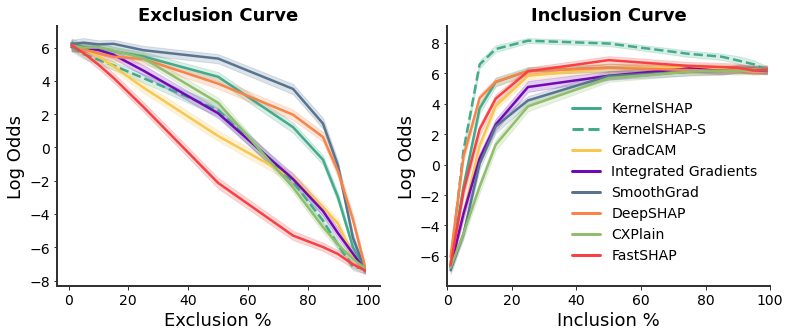

In [19]:
import itertools
method_names = ['FastSHAP', 'KernelSHAP', 'KernelSHAP-S', 'GradCAM', 
                'Integrated Gradients', 'SmoothGrad', 'DeepSHAP','CXPlain']
log_odds_out = []
for method in methods:
    df =  pd.DataFrame([(int(k), np.mean(v), 
                         np.percentile(v, 5), np.percentile(v, 95)) for k, v in all_results_out[method]['bootstrap_log_odds'].items()])
    df.columns = ['Exclusion %', method, method+'_lower', method+'_upper']
    log_odds_out.append(df)

log_odds_out = reduce(lambda x, y: pd.merge(x, y, on = 'Exclusion %'), log_odds_out)
log_odds_out.columns = ['Exclusion %'] + list(itertools.chain(*[[x, x+'_lower', x+'_upper'] for x in method_names]))

#### FIGURE #####
colors = {'FastSHAP':'#f94144', 'KernelSHAP':'#43aa8b', 'KernelSHAP-S':'#43aa8b', 
          'GradCAM':'#f9c74f', 'Integrated Gradients':'#7209b7', 
          'SmoothGrad':'#577590', 'DeepSHAP':'#f9844a', 'CXPlain':'#90be6d'}

fig, axs = plt.subplots(1, 2, figsize=(14*.8, 7*.7))
for method in method_names[1:] + ['FastSHAP']:
    if method == 'KernelSHAP-S':
        axs[0].plot(log_odds_out['Exclusion %'], log_odds_out[method],
                 label=method, color=colors[method], linestyle='--')
    else:
        axs[0].plot(log_odds_out['Exclusion %'], log_odds_out[method],
                 label=method, color=colors[method])
    axs[0].fill_between(log_odds_out['Exclusion %'],
                     log_odds_out[method+'_lower'] ,
                     log_odds_out[method+'_upper'],
                     color=colors[method], alpha=0.2)
axs[0].set_xlabel('Exclusion %')
axs[0].set_ylabel('Log Odds')
axs[0].set_title('Exclusion Curve')


log_odds_in = []
for method in methods:
    df =  pd.DataFrame([(int(k), np.mean(v), 
                         np.percentile(v, 5), np.percentile(v, 95)) for k, v in all_results_in[method]['bootstrap_log_odds'].items()])
    df.columns = ['Inclusion %', method, method+'_lower', method+'_upper']
    log_odds_in.append(df)

log_odds_in = reduce(lambda x, y: pd.merge(x, y, on = 'Inclusion %'), log_odds_in)
log_odds_in.columns = ['Inclusion %'] + list(itertools.chain(*[[x, x+'_lower', x+'_upper'] for x in method_names]))

for method in method_names[1:] + ['FastSHAP']:
    if method == 'KernelSHAP-S':
        axs[1].plot(log_odds_in['Inclusion %'], log_odds_in[method],
                 label=method, color=colors[method], linestyle='--')
    else:
        axs[1].plot(log_odds_in['Inclusion %'], log_odds_in[method],
                 label=method, color=colors[method])
    axs[1].fill_between(log_odds_in['Inclusion %'],
                     log_odds_in[method+'_lower'] ,
                     log_odds_in[method+'_upper'],
                     color=colors[method], alpha=0.2)

axs[1].set_xlabel('Inclusion %')
axs[1].set_ylabel('Log Odds')
axs[1].set_title('Inclusion Curve')

leg = axs[1].legend(loc='right',
                      bbox_to_anchor=(1, 0.4),
                      fancybox=False,
                      shadow=False,
                      ncol=1,
                      fontsize=14,
                      frameon=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)


# plt.ylim(0, .95)
plt.xlim(0, 100)
plt.tick_params(labelsize=14)
plt.tight_layout()

pdf = PdfPages(os.path.join(results_dir, 'curves_log-odds.pdf'))
pdf.savefig(pad_inches=0, bbox_inches='tight')
pdf.close()

plt.show()

## AUCs

### Accuracy

In [22]:
from sklearn.metrics import auc
for method, name in zip(methods, method_names):
    # Exlcusion
    auc_outs = []
    for i in range(100):
        x = []
        y = []
        for p in all_results_out[method]['bootstrap_acc'].keys():
            x.append(float(p))
            y.append(all_results_out[method]['bootstrap_acc'][p][i])
        auc_outs.append(auc(np.array(x), np.array(y)))
    auc_outs = np.array(auc_outs)/100
    
    # Inclusion
    auc_ins = []
    for i in range(100):
        x = []
        y = []
        for p in all_results_in[method]['bootstrap_acc'].keys():
            x.append(float(p))
            y.append(all_results_in[method]['bootstrap_acc'][p][i])
        auc_ins.append(auc(np.array(x), np.array(y)))
    auc_ins = np.array(auc_ins)/100
    
    # Print
    print('{} & {:.2f} ({:.2f}, {:.2f}) & {:.2f} ({:.2f}, {:.2f})'.format(name, 
                                                                        auc_outs.mean(), 
                                                                        np.percentile(auc_outs, 2.5), 
                                                                        np.percentile(auc_outs, 97.5), 
                                                                        auc_ins.mean(), 
                                                                        np.percentile(auc_ins, 2.5), 
                                                                        np.percentile(auc_ins, 97.5)))

FastSHAP & 0.42 (0.41, 0.43) & 0.78 (0.77, 0.80)
KernelSHAP & 0.64 (0.63, 0.65) & 0.78 (0.77, 0.80)
KernelSHAP-S & 0.54 (0.52, 0.55) & 0.86 (0.85, 0.87)
GradCAM & 0.52 (0.51, 0.54) & 0.76 (0.75, 0.78)
Integrated Gradients & 0.55 (0.54, 0.56) & 0.74 (0.73, 0.75)
SmoothGrad & 0.70 (0.69, 0.71) & 0.72 (0.71, 0.74)
DeepSHAP & 0.65 (0.64, 0.66) & 0.79 (0.78, 0.80)
CXPlain & 0.56 (0.55, 0.57) & 0.71 (0.70, 0.72)


### Log Odds

In [23]:
from sklearn.metrics import auc
for method, name in zip(methods, method_names):
    # Exlcusion
    auc_outs = []
    for i in range(100):
        x = []
        y = []
        for p in all_results_out[method]['bootstrap_log_odds'].keys():
            x.append(float(p))
            y.append(all_results_out[method]['bootstrap_log_odds'][p][i])
        y -= np.array(y).min()
        auc_outs.append(auc(np.array(x), np.array(y)))
    auc_outs = np.array(auc_outs)/100
    
    # Inclusion
    auc_ins = []
    for i in range(100):
        x = []
        y = []
        for p in all_results_in[method]['bootstrap_log_odds'].keys():
            x.append(float(p))
            y.append(all_results_in[method]['bootstrap_log_odds'][p][i])
        auc_ins.append(auc(np.array(x), np.array(y)))
    auc_ins = np.array(auc_ins)/100
    
    # Print
    print('{} & {:.2f} ({:.2f}, {:.2f}) & {:.2f} ({:.2f}, {:.2f})'.format(name, 
                                                                        auc_outs.mean(), 
                                                                        np.percentile(auc_outs, 2.5), 
                                                                        np.percentile(auc_outs, 97.5), 
                                                                        auc_ins.mean(), 
                                                                        np.percentile(auc_ins, 2.5), 
                                                                        np.percentile(auc_ins, 97.5)))

FastSHAP & 5.92 (5.62, 6.14) & 5.36 (5.16, 5.63)
KernelSHAP & 9.88 (9.55, 10.20) & 5.36 (5.14, 5.63)
KernelSHAP-S & 8.01 (7.68, 8.34) & 6.80 (6.65, 6.96)
GradCAM & 7.75 (7.44, 8.09) & 4.99 (4.81, 5.26)
Integrated Gradients & 8.34 (8.03, 8.61) & 4.58 (4.37, 4.85)
SmoothGrad & 10.99 (10.67, 11.29) & 4.30 (4.08, 4.58)
DeepSHAP & 9.96 (9.61, 10.24) & 5.47 (5.28, 5.76)
CXPlain & 8.34 (8.00, 8.58) & 4.02 (3.80, 4.31)


# Runtimes

### Explaining

In [24]:
methods = ['fastshap', 'kernelshap', 'kernelshap_plus', 'gradcam', 'integratedgradients', 'smoothgrad', 'deepshap', 'cxplain']
for method, name in zip(methods, method_names):
    evaluation_results = {}
    
    #################### Load Masks ####################
    if method in ['gradcam', 'integratedgradients', 'smoothgrad','deepshap']:
        method_dir = os.path.join('../', method) 
    else:
        method_dir = os.path.join('../', method, 'results')
    
    with open(os.path.join(method_dir, 'explaining_time.pkl'), 'rb') as f:
        explaining_time = pickle.load(f)
        
    if method in ['kernelshap', 'kernelshap_plus']:
        explaining_time *= 60
    else:
        explaining_time /= 60
        
    print('{} & {:.2f}'.format(name, explaining_time))

FastSHAP & 0.04
KernelSHAP & 453.69
KernelSHAP-S & 460.10
GradCAM & 0.38
Integrated Gradients & 0.91
SmoothGrad & 1.00
DeepSHAP & 5.39
CXPlain & 0.03


### Training

In [25]:
from pathlib import Path

for method in ['fastshap', 'surrogate', 'cxplain']:
    method_dir = os.path.join('../', method)
    model_path = sorted(Path(method_dir).iterdir(), key=os.path.getmtime)[-1]
    
    with open(os.path.join(model_path, 'training_time.pkl'), 'rb') as f:
        training_time = pickle.load(f)
        
    training_time /= 60
    
    print('{} & {:.2f}'.format(method, training_time))

fastshap & 331.54
surrogate & 362.03
cxplain & 538.49
